# ECO5050 Assignment 1

We will replicate the empirical example in Lecture 3 slides, based on Welch and Goyal (2008).

Some of the code is borrowed from the source below: \
https://github.com/yniu87/EquityPremium/blob/master/312_Predicting_equity_premium.ipynb

The data comes from Amit Goyal's website: \
https://sites.google.com/view/agoyal145






In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import math
import warnings
import itertools
warnings.simplefilter("ignore", UserWarning)

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm


In [4]:
# Import data and show the last 10 observations
df = pd.read_excel("Welch_Goyal_PredictorData2023.xlsx", sheet_name='Quarterly')
df.tail(10)

,yyyyq,Index,D12,E12,b/m,tbl,AAA,BAA,lty,cay,...,infl,ltr,corpr,svar,csp,ik,CRSP_SPvw,CRSP_SPvwx,D3,E3
602,20213,4307.54,59.254483,175.37,0.188541,0.0004,0.0253,0.0323,0.0137,-0.069219,...,0.009621,0.001221,-0.000482,0.003120,NaN,0.033512,0.007009,0.003535,15.359000,49.59
603,20214,4766.18,60.397117,197.87,0.175599,0.0006,0.0265,0.0330,0.0147,-0.052766,...,0.016376,0.014919,0.012221,0.004996,NaN,0.033451,0.108956,0.105195,15.783466,53.94
604,20221,4530.41,61.969974,197.91,0.206653,0.0044,0.0343,0.0429,0.0213,-0.043082,...,0.031212,-0.055753,-0.076871,0.011203,NaN,0.034024,-0.045115,-0.048560,16.250101,45.99
605,20222,3785.38,64.019605,192.26,0.232861,0.0149,0.0424,0.0527,0.0314,-0.028864,...,0.030633,-0.037749,-0.072570,0.019890,NaN,0.034158,-0.161792,-0.165304,16.627038,42.74
606,20223,3585.62,65.318305,187.08,0.249478,0.0313,0.0459,0.0569,0.0352,-0.027858,...,0.001677,-0.043479,-0.050566,0.011470,NaN,0.034241,-0.046349,-0.050490,16.657700,44.41
607,20224,3839.50,66.922828,172.75,0.216199,0.0425,0.0443,0.0559,0.0362,-0.020875,...,-0.000037,0.007221,0.036339,0.015548,NaN,0.034075,0.071819,0.067163,17.387989,39.61
608,20231,4109.31,68.211442,175.17,0.220060,0.0469,0.0460,0.0571,0.0366,-0.020240,...,0.016978,0.030049,0.035021,0.006916,NaN,0.034243,0.076900,0.072284,17.538715,48.41
609,20232,4450.38,68.714936,181.01,0.212811,0.0516,0.0465,0.0575,0.0375,-0.018591,...,0.010844,-0.013775,-0.002851,0.003512,NaN,0.034544,0.088719,0.084395,17.130532,48.58
610,20233,4288.05,69.313136,184.25,0.218528,0.0532,0.0513,0.0616,0.0438,-0.012995,...,0.008784,-0.030606,-0.030927,0.002897,NaN,0.034341,-0.032530,-0.036230,17.255900,47.65
611,20234,4769.83,70.303692,192.43,0.194280,0.0524,0.0474,0.0564,0.0402,-0.008255,...,-0.003389,0.056625,0.085022,0.003816,NaN,0.034337,0.116225,0.111510,18.378545,47.79


We will use 11 variables as predictors: 

log divididend-price ratio (dp), log dividend yield (dy), log earnings-price ratio (ep), book-to-market ratio (bm), net equity issues (ntis), three-month T-bill rate (tbl), long term returns (ltr), term spread (tms), default yield (dfy), inflation (infl), investiment-capital ratio (ik)

Some predictors need to be generated from raw data.

In [6]:
# equity premium, i.e., the total rate of return on the stock market minus the prevailing short-term interest rate.
df['premium'] = df['CRSP_SPvw'] - df['Rfree']

# Dividend Price Ratio (dp) is the difference between the log of dividends and the log of prices. 
df['dp'] = np.log(df['D12']) - np.log(df['Index'])

# Dividend Yield (dy) is the difference between the log of dividends and the log of lagged prices.
df['dy'] = np.log(df['D12'])- np.log(df['Index'].shift(1))

# Earnings Price Ratio (ep) is the difference between the log of earnings and the log of prices.
df['ep'] = np.log(df['E12']) - np.log(df['Index'])

# Term Spread (tms) is the difference between the long term yield on government bonds and the T-bill.
df['tms'] = df['lty'] - df['tbl']

# Default Yield Spread (dfy): is the difference between BAA- and AAA- rated cor- porate bond yields.
df['dfy'] = df['BAA'] - df['AAA']

# Rename 'b/m' to 'bm'
df = df.rename(columns={'b/m':'bm'})

# List of predictors names
x_names = ['dp', 'dy', 'ep','bm', 'ntis', 'tbl', 'ltr', 'tms', 'dfy', 'infl', 'ik']


# Create a 'date' column from 'year' and 'quarter'
df['year'] = df['yyyyq'].astype(str).str[:4].astype(int)  # Extract the year
df['quarter'] = df['yyyyq'].astype(str).str[4].astype(int)  # Extract the quarter
df['date'] = pd.PeriodIndex(year=df['year'], quarter=df['quarter'], freq='Q')



Below is a plot of the stock return values from 1970Q1 to 2023Q4.

You can check the correlation between predictors and stock return by plotting a heatmap of correlation for the entire data set.



In [7]:
df_y = df.copy()
df_y.set_index('date', inplace=True)
df_y

,yyyyq,Index,D12,E12,bm,tbl,AAA,BAA,lty,cay,...,D3,E3,premium,dp,dy,ep,tms,dfy,year,quarter
date,,,,,,,,,,,,,,,,,,,,,
1871Q1,18711,4.61,0.260000,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.875302,NaN,-2.444519,NaN,NaN,1871,1
1871Q2,18712,4.82,0.260000,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.919848,-2.875302,-2.489065,NaN,NaN,1871,2
1871Q3,18713,4.84,0.260000,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.923988,-2.919848,-2.493205,NaN,NaN,1871,3
1871Q4,18714,4.74,0.260000,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.903111,-2.923988,-2.472328,NaN,NaN,1871,4
1872Q1,18721,5.04,0.270000,0.4075,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.926739,-2.865370,-2.515120,NaN,NaN,1872,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022Q4,20224,3839.50,66.922828,172.7500,0.216199,0.0425,0.0443,0.0559,0.0362,-0.020875,...,17.387989,39.61,0.063994,-4.049557,-3.981147,-3.101252,-0.0063,0.0116,2022,4
2023Q1,20231,4109.31,68.211442,175.1700,0.220060,0.0469,0.0460,0.0571,0.0366,-0.020240,...,17.538715,48.41,0.066275,-4.098398,-4.030485,-3.155253,-0.0103,0.0111,2023,1
2023Q2,20232,4450.38,68.714936,181.0100,0.212811,0.0516,0.0465,0.0575,0.0375,-0.018591,...,17.130532,48.58,0.076994,-4.170778,-4.091044,-3.202192,-0.0141,0.0110,2023,2


In [8]:
# Convert the PeriodIndex to DatetimeIndex
stock_return = df_y.loc['1970Q1':, 'premium']
stock_return.index = stock_return.index.to_timestamp()  # Convert PeriodIndex to DatetimeIndex
stock_return

date
1970-01-01   -0.037166
1970-04-01   -0.197470
1970-07-01    0.151541
1970-10-01    0.090881
1971-01-01    0.085824
                ...   
2022-10-01    0.063994
2023-01-01    0.066275
2023-04-01    0.076994
2023-07-01   -0.045430
2023-10-01    0.102925
Freq: QS-OCT, Name: premium, Length: 216, dtype: float64

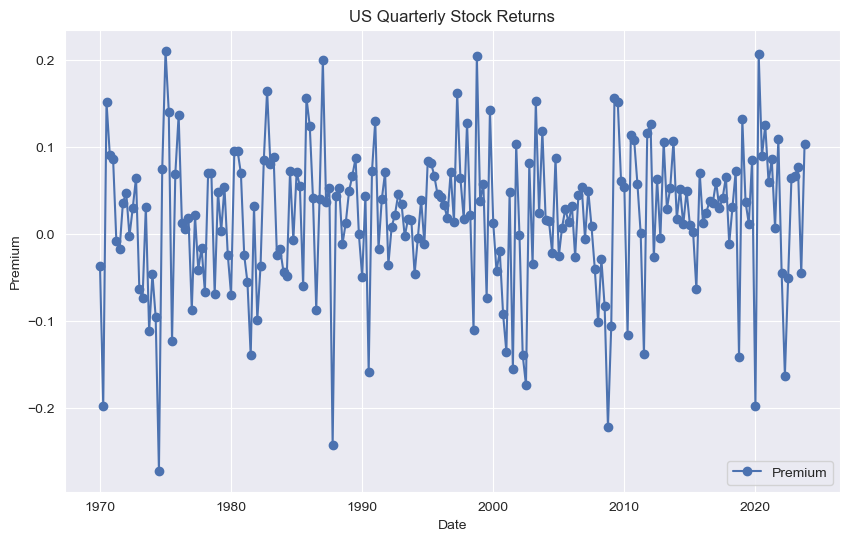

In [9]:
# Plotting the actual stock return values
with sns.color_palette('deep'): #seaborn의 색상팔레트 적용
        
    plt.figure(figsize=(10, 6))
    plt.plot(stock_return.index, stock_return, label='Premium', marker='o')
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Premium')
    plt.title('US Quarterly Stock Returns')
    plt.legend()

    # Display the plot
    plt.show()

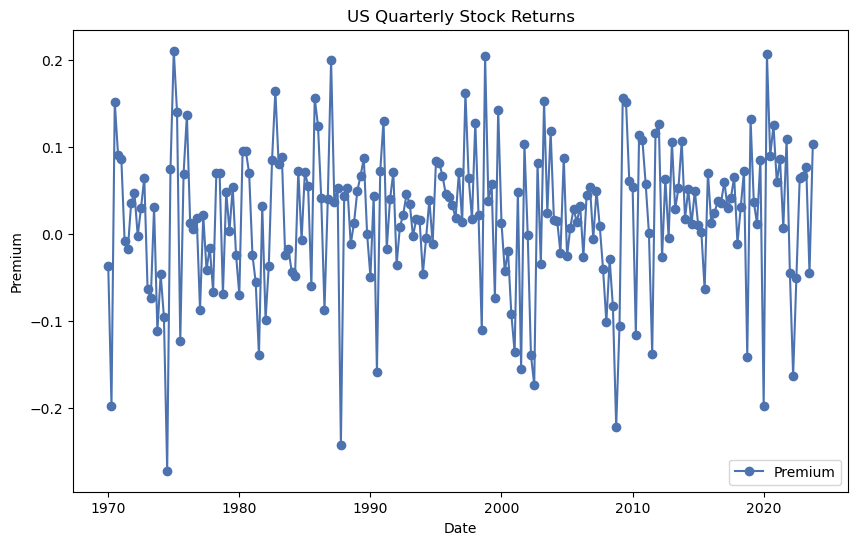

In [5]:
df_y = df.copy()
df_y.set_index('date', inplace=True)

# Convert the PeriodIndex to DatetimeIndex
stock_return = df_y.loc['1970Q1':, 'premium']
stock_return.index = stock_return.index.to_timestamp()  # Convert PeriodIndex to DatetimeIndex


# Plotting the actual stock return values
with sns.color_palette('deep'): #seaborn의 색상팔레트 적용
        
    plt.figure(figsize=(10, 6))
    plt.plot(stock_return.index, stock_return, label='Premium', marker='o')
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Premium')
    plt.title('US Quarterly Stock Returns')
    plt.legend()

    # Display the plot
    plt.show()

In [10]:
features = df[['premium'] + x_names]
features

,premium,dp,dy,ep,bm,ntis,tbl,ltr,tms,dfy,infl,ik
0,NaN,-2.875302,NaN,-2.444519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-2.919848,-2.875302,-2.489065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,-2.923988,-2.919848,-2.493205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,-2.903111,-2.923988,-2.472328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,-2.926739,-2.865370,-2.515120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
607,0.063994,-4.049557,-3.981147,-3.101252,0.216199,-0.021255,0.0425,0.007221,-0.0063,0.0116,-0.000037,0.034075
608,0.066275,-4.098398,-4.030485,-3.155253,0.220060,-0.022332,0.0469,0.030049,-0.0103,0.0111,0.016978,0.034243
609,0.076994,-4.170778,-4.091044,-3.202192,0.212811,-0.015674,0.0516,-0.013775,-0.0141,0.0110,0.010844,0.034544
610,-0.045430,-4.124953,-4.162110,-3.147294,0.218528,-0.017989,0.0532,-0.030606,-0.0094,0.0103,0.008784,0.034341


In [11]:
corr = features.corr()
corr

,premium,dp,dy,ep,bm,ntis,tbl,ltr,tms,dfy,infl,ik
premium,1.000000,-0.102327,0.108840,-0.110970,-0.103832,-0.063848,-0.091971,0.004649,0.052750,-0.116400,-0.028678,-0.199025
dp,-0.102327,1.000000,0.979984,0.726013,0.820992,0.258528,0.047741,-0.012054,-0.105167,0.461531,0.023341,-0.204665
dy,0.108840,0.979984,1.000000,0.711065,0.794566,0.247519,0.045445,-0.012965,-0.102710,0.425713,0.022778,-0.228777
ep,-0.110970,0.726013,0.711065,1.000000,0.691951,0.165321,0.269849,0.010553,-0.248594,0.103997,0.243898,-0.002991
bm,-0.103832,0.820992,0.794566,0.691951,1.000000,0.048691,0.194249,-0.002318,-0.022179,0.457025,0.086220,-0.047886
ntis,-0.063848,0.258528,0.247519,0.165321,0.048691,1.000000,0.016318,-0.078213,-0.159199,-0.177369,-0.065413,-0.050079
tbl,-0.091971,0.047741,0.045445,0.269849,0.194249,0.016318,1.000000,0.017211,-0.407511,-0.035205,0.253037,0.482021
ltr,0.004649,-0.012054,-0.012965,0.010553,-0.002318,-0.078213,0.017211,1.000000,0.109813,0.132101,-0.172356,0.005094
tms,0.052750,-0.105167,-0.102710,-0.248594,-0.022179,-0.159199,-0.407511,0.109813,1.000000,0.198138,-0.072085,-0.400659
dfy,-0.116400,0.461531,0.425713,0.103997,0.457025,-0.177369,-0.035205,0.132101,0.198138,1.000000,-0.280750,-0.089242


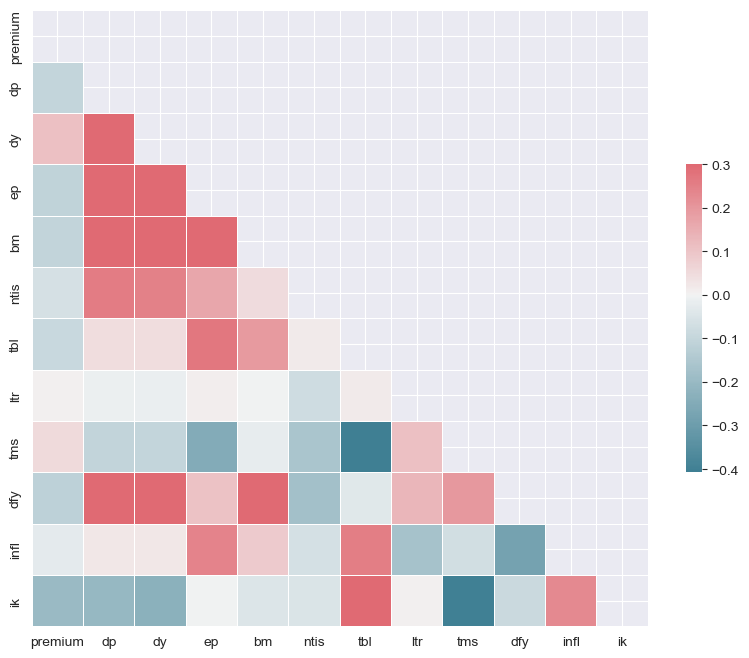

<Figure size 640x480 with 0 Axes>

In [16]:
# Optional: Draw a heatmap of correlation

features = df[['premium'] + x_names]

corr = features.corr()

# Generate a mask for the upper triangle
#대각선 아래는 false, 위에는 true인 corr과 크기가 동일한 행렬 생성
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))




# Generate a custom diverging colormap
#데이터의 중심을 기준으로 두 가지 색상이 갈라지는 특성
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

#Save the plot as a PNG file
plt.savefig("correlation_heatmap.png", format="png", dpi=300)

Now pick the predictors and lag them by one quarter. Concatenate with the stock return we want to forecast, 'premium'. Drop rows if any variable has null values. We have a dataframe that starts in 1947Q2 and ends in 2023Q4. 

In [17]:
# Lag the predictors and drop rows if any of the variables has null values
# 예측 변수의 시차를 적용해 프리미엄 예측 시 이전 시점의 변수들을 사용하는 형태
df_clean = pd.concat([df[['date', 'premium']], df[x_names].shift(1)], axis=1 )
#시프트로 인해 첫번재 행이 nan이므로 이 행(axis=0)을 삭제
df_clean = df_clean.dropna(axis=0)
df_clean

,date,premium,dp,dy,ep,bm,ntis,tbl,ltr,tms,dfy,infl,ik
305,1947Q2,0.010343,-3.047824,-3.056357,-2.480303,0.741535,0.031020,0.0038,0.003502,0.0175,0.0060,0.018605,0.035902
306,1947Q3,0.004550,-2.996390,-2.993757,-2.357310,0.741117,0.026473,0.0038,0.000587,0.0178,0.0066,0.004566,0.034959
307,1947Q4,0.031446,-2.951079,-2.957675,-2.277102,0.740323,0.024059,0.0080,0.009987,0.0133,0.0062,0.045455,0.033978
308,1948Q1,-0.003618,-2.902206,-2.889710,-2.251619,0.725326,0.025922,0.0095,-0.039832,0.0148,0.0066,0.017391,0.034613
309,1948Q2,0.123489,-2.875888,-2.890372,-2.176876,0.841422,0.027187,0.0100,0.010032,0.0141,0.0070,0.000000,0.036276
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2022Q4,0.063994,-4.005414,-4.059629,-2.953150,0.249478,-0.011292,0.0313,-0.043479,0.0039,0.0110,0.001677,0.034241
608,2023Q1,0.066275,-4.049557,-3.981147,-3.101252,0.216199,-0.021255,0.0425,0.007221,-0.0063,0.0116,-0.000037,0.034075
609,2023Q2,0.076994,-4.098398,-4.030485,-3.155253,0.220060,-0.022332,0.0469,0.030049,-0.0103,0.0111,0.016978,0.034243
610,2023Q3,-0.045430,-4.170778,-4.091044,-3.202192,0.212811,-0.015674,0.0516,-0.013775,-0.0141,0.0110,0.010844,0.034544


Note that the predictor variables are lagged, so the predictors are from 1947Q1-2023Q3, and stock return from 1947Q2-2023Q4, 

Now you are ready to solve the questions. For questions 2 and 3 we focus on one window: data up to 2023Q3 is the estimation sample (training set) for estimating the forecast model, and then we generate the out-of-sample forecast for 2023Q4

Here are some example codes that might help. Below is a loop that estimates the linear regression model with all possible combinations of predictors. The best_model is the model that has the minimum squared forecast error for 2023Q4 and best_selected_x is the list of selected predictors.

In [20]:
current_date = '2023Q4'
forecast_date = '1970Q1'

#2023년 3분기까지의 데이터 중 x_names의 리스트에 퐣ㅁ된 모든 변수를 포함한 훈련 데이터의 특성행렬을 생성
X_train = df_clean.loc[df_clean['date'] <= current_date, x_names]
y_train = df_clean.loc[df_clean['date'] <= current_date, 'premium']

#2023년 4분기의 test데이터 생성
X_test = df_clean.loc[df_clean['date'] == forecast_date, x_names]
y_test = df_clean.loc[df_clean['date'] == forecast_date, 'premium']


In [21]:
# Initialize best squared error to a very large number
best_squared_error = np.inf  
#현재까지 찾은 제곱 오차 무한대로 초기화. 오차는 무조건 무한대보다 작아지므로 초기값으로 적합.
best_model = None
best_selected_features = None

# Iterate over all combinations of predictors
for i in range(1, len(x_names) + 1):
    for combo in itertools.combinations(x_names, i):
        #모든 예측변수의 조합을 시도하여 최적의 모델 find
        # Train model for the current combination of features
        X_train_selected = sm.add_constant(X_train[list(combo)])
        #선택된 예측 변수를 포함하는 훈련 데이터에 상수항을 추가(OLS 회귀모델이 절편을 포함시키게)
        model = sm.OLS(y_train, X_train_selected).fit()
        
        # Generate out-of-sample forecast for 2023Q4
        # Manually add the constant column (intercept) because X_test has one row
        X_test_selected = X_test[list(combo)].copy()
        X_test_selected.insert(0, 'const', 1)
    
        # forecast and squared forecast error
        forecast = model.predict(X_test_selected)
        squared_error = (y_test - forecast)**2

        # Check if this is the best model based on the squared forecast error
        if squared_error.iloc[0] < best_squared_error:
            #현재 조합의 제곱 오차가 이전까지의 최적오차보다 작은 지 확인
            best_squared_error = squared_error.iloc[0]
            #테스트 세트가 단일 행이므로 첫 번째 요소 가져옴
            best_model = model
            best_selected_x = list(combo)
            
            
            
print(f"Selected predictors: {best_selected_x}")#최적의 예측변수 조합 프린트
print(f"Actual stock return value: {y_test.iloc[0].round(4)} and the forecast {forecast.iloc[0].round(4)}")
print(f"Squared forecast error: {best_squared_error}")

Selected predictors: ['dp', 'ep', 'bm', 'ntis', 'tbl', 'infl']
Actual stock return value: -0.0372 and the forecast -0.0275
Squared forecast error: 2.41874937656927e-10
